In [1]:
#!wget https://github.com/unburied/DS-Unit-2-Applied-Modeling/raw/master/data/caterpillar/caterpillar-tube-pricing.zip

In [2]:
#!unzip -n caterpillar-tube-pricing.zip 

In [3]:
#!unzip data.zip

In [4]:
from glob import glob
import pandas as pd

#load data into df dictionary and clean names as keys
df_dict = {}
for file in glob('competition_data/*'):
    name = file.replace('competition_data/', '').replace('.csv', '')
    df_dict[name] = pd.read_csv(file) 

In [5]:
df_dict.keys()

dict_keys(['type_end_form', 'comp_elbow', 'bill_of_materials', 'type_connection', 'comp_float', 'components', 'tube_end_form', 'tube', 'test_set', 'comp_other', 'comp_boss', 'comp_adaptor', 'specs', 'type_component', 'train_set', 'comp_nut', 'comp_threaded', 'comp_straight', 'comp_tee', 'comp_sleeve', 'comp_hfl'])

In [6]:
#extract data to split and begin exploration
trainval = df_dict['train_set']
test = df_dict['test_set']

In [7]:
trainval.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [8]:
#get unique id's for assemblies to split
train_tubes = trainval.tube_assembly_id.unique()
test_tubes = test.tube_assembly_id.unique()

set(train_tubes) & set(test_tubes)

set()

In [9]:
from sklearn.model_selection import train_test_split

#split for train and validation
train_assemblies, val_assemblies = train_test_split(train_tubes,
                                                   random_state = 42)
#confirm both sets have unique assemblies
set(train_assemblies) & set(val_assemblies)

set()

In [10]:
#split trainval in train and val subsets
train = trainval[trainval.tube_assembly_id.isin(train_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_assemblies)]

assert len(train) + len(val) == len(trainval)

In [11]:
#get baseline == mean
import numpy as np

target = 'cost'

#set target and predictions
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value = y_train.mean())

In [12]:
#score baseline
from sklearn.metrics import mean_squared_log_error

def rmsle(pred, true):
    score = np.sqrt(mean_squared_log_error(pred, true))
    statement = f'Score = {score}'
    return print(statement)

In [13]:
rmsle(y_pred, y_val)

Score = 0.9418101276064408


In [14]:
#use simple model to build upon baseline
from sklearn.ensemble import RandomForestRegressor

#use numerical feature quantity for model baseline
feature = ['quantity']
X_train = train[feature]
X_val = val[feature]

#fit model
model = RandomForestRegressor(n_estimators = 350, max_depth = 20)
model.fit(X_train, y_train)

#get score
y_pred = model.predict(X_val)
rmsle(y_pred, y_val)

Score = 0.6911832561706374


In [15]:
#wrangle data
def wrangle(df):
    X = df.copy()
    
    #merge related columns for separate files
    X = mash(X)
    
    #add bills data
    X = X.merge(clean_bills(df_dict['bill_of_materials']), how = 'left')
    
    X['quote_date'] = pd.to_datetime(X.quote_date, infer_datetime_format = True)
    X['year'] = X.quote_date.dt.year
    X['month'] = X.quote_date.dt.month
    X['day'] = X.quote_date.dt.day
    X['day_of_year'] = X.quote_date.dt.dayofyear
    X['day_of_week'] = X.quote_date.dt.dayofweek
    
    X['component_id'] = X.component_id_1
    X = X.merge(df_dict['tube'], how = 'left')
    X = X.merge(df_dict['components'], how = 'left')
    X = X.merge(df_dict['type_component'], how = 'left')
    
    drop = ['quote_date', 'tube_assembly_id','other', 'component_id_1']
    X = X.drop(columns = drop)
    
    
    
    return X

In [16]:
#function to merge all data
def mash(X):
    X = X.copy()
    for k,v in df_dict.items():
        #determine if columns share values
        shared_columns = set(X.columns) & set(v.columns)
        #if so merge
        if shared_columns:
            X = X.merge(v, how = 'left')
    #drop columns that contain NA for now
    X = X.dropna(axis = 1)        
    return X

In [17]:
def clean_bills(df):
    id_info = df.copy()
    
    #initialize a columns of zeros to count up from
    id_info['num_of_comps'] = [0 for _ in range(id_info.shape[0])]
    id_info['total_quantity'] = [0 for _ in range(id_info.shape[0])]
    
    #increment new columns for any column not containing a null value
    for col in range(1,9):
        id_info['num_of_comps'] = np.where(id_info[f'component_id_{col}'].isnull(),
                                           id_info.num_of_comps , id_info.num_of_comps + 1)
        id_info['total_quantity'] = np.where(id_info[f'quantity_{col}'].isnull(),
                                           id_info.total_quantity , 
                                           id_info.total_quantity + id_info[f'quantity_{col}'])
        
    #return df filtered with new columns and 3 components ids
    filters = ['component_id_1','component_id_2','component_id_3',
               'num_of_comps', 'total_quantity', 'tube_assembly_id']
    
    return id_info[filters]

In [18]:
#wrangle data and pop targets
y_train = train.pop('cost')
y_val = val.pop('cost')
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [19]:
#tie up loose ends
train_wrangled = train_wrangled.drop(columns = 'cost')
val_wrangled = val_wrangled.drop(columns = 'cost')
test_wrangled = test_wrangled.drop(columns = 'id')

In [20]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

#make pipeline to encode and model data
pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestRegressor(n_estimators = 150,
                                             max_depth = 20,
                                             n_jobs = -1))
#fit data and get score
pipeline.fit(train_wrangled, y_train)
y_pred = pipeline.predict(val_wrangled)
rmsle(y_pred, y_val)

Score = 0.2963899300923012


In [21]:
def submission(test, attempt):   
    attempt = 'submission-' + str(attempt) + '.csv'
    sample_submission = pd.read_csv('sample_submission.csv')
    submission = sample_submission.copy()
    submission['cost'] = np.expm1(pipeline.predict(test))
    submission.to_csv(attempt, index=False)

In [22]:
#convert to log values
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [23]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_job=-1))
    
pipeline.fit(train_wrangled, y_train_log)
y_pred_log = pipeline.predict(val_wrangled)

/home/unburied/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:13:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
#score baseline
from sklearn.metrics import mean_squared_error

def rmse(pred, true):
    score = np.sqrt(mean_squared_error(pred, true))
    statement = f'Score = {score}'
    return print(statement)

In [25]:
rmse(y_pred_log, y_val_log)

Score = 0.2657981713355923


In [26]:
#submission(test_wrangled, 4)
pipeline.named_steps['xgbregressor']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_job=-1, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = range(1000, 3000, 250)
max_depth = range(1,5)
learning_rate = [.1, .5, 1 , 2]

param_distributions = {
    'xgbregressor__n_estimators' : n_estimators,
    'xgbregressor__max_depth' : max_depth,
    'xgbregressor__learning_rate' : learning_rate,
    }
tuner = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 25,
    cv = 4,
    return_train_score = True,
    n_jobs = 3)

In [28]:
#tuner.fit(train_wrangled, y_train_log)

In [29]:
#tuner.best_params_

In [30]:
#y_pred_log = tuner.estimator.predict(val_wrangled)
#rmse(y_pred_log,y_val_log)

In [31]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=2000,
                 max_depth = 4,
                 n_job=-1))
    
pipeline.fit(train_wrangled, y_train_log)

/home/unburied/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['supplier', 'bracket_pricing', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'component_id_2', 'component_id_3', 'component_id', 'material_id', 'name', 'component_type_id'],
        drop_invariant=False, handle_unknown='impute', impu...lpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1))])

In [32]:
#submission(test_wrangled, 5)

In [33]:
#will add an ensabmle of features on next iteration

In [34]:
#!pip install eli5 pdpbox 

    100% |████████████████████████████████| 102kB 768kB/s a 0:00:01
    100% |████████████████████████████████| 57.7MB 788kB/s eta 0:00:01    81% |██████████████████████████      | 47.0MB 30.5MB/s eta 0:00:01    85% |███████████████████████████▍    | 49.3MB 29.8MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 33.3MB/s ta 0:00:01
  Stored in directory: /home/unburied/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
  Stored in directory: /home/unburied/.cache/pip/wheels/2b/67/89/414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built pdpbox tabulate


In [63]:
import eli5
from eli5.sklearn import PermutationImportance

#data order should be same order as train_test_split output
#model should be untrained
def show_weights(data, model):
    
    #encode data
    encode = ce.OrdinalEncoder()
    data[0] = encode.fit_transform(data[0])
    data[1] = encode.transform(data[1])
    
    #extract columns and convert to matrix for permuter
    columns = data[1].columns.tolist()
    data = [x.as_matrix() for x in data]
    
    #fit
    model.fit(data[0], data[2])
    
    #custom scoring function for permuter
    def scoring(estimator, X, y_true):
        y_pred = estimator.predict(X)
        return -np.sqrt(mean_squared_error(y_true, y_pred))
    
    #initialize permuter with 5 iterations
    permuter = PermutationImportance(model,
                                    scoring = scoring,
                                    cv = 'prefit',
                                    n_iter = 5,
                                    random_state = 42)
    #fit
    permuter.fit(data[1], data[3])
     
    #return plotted weights   
    return eli5.show_weights(permuter,
                             top = None,
                             feature_names = columns)

In [64]:
#arragne data for show_weights function
data = [train_wrangled, val_wrangled, y_train_log, y_val_log]

#initialize an untrained model to produce weights
model = XGBRegressor(n_estimators=2000,
                     max_depth = 4,
                     n_job= 3)

#get and plot weights
show_weights(data,model)

[23:14:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.6442 ± 0.0057,quantity
0.2955 ± 0.0030,min_order_quantity
0.1249 ± 0.0047,diameter
0.1146 ± 0.0056,supplier
0.1048 ± 0.0049,annual_usage
0.0670 ± 0.0060,year
0.0492 ± 0.0010,component_id_3
0.0408 ± 0.0036,name
0.0379 ± 0.0027,length
0.0354 ± 0.0026,wall


In [65]:
from pdpbox.pdp import pdp_isolate, pdp_plot

#diameter was 3rd most weighted feature
feature = 'diameter'

#initialize a pdp_isolate
isolated = pdp_isolate(model = pipeline,
                       dataset = val_wrangled, 
                       model_features = val_wrangled.columns,
                       feature = feature)

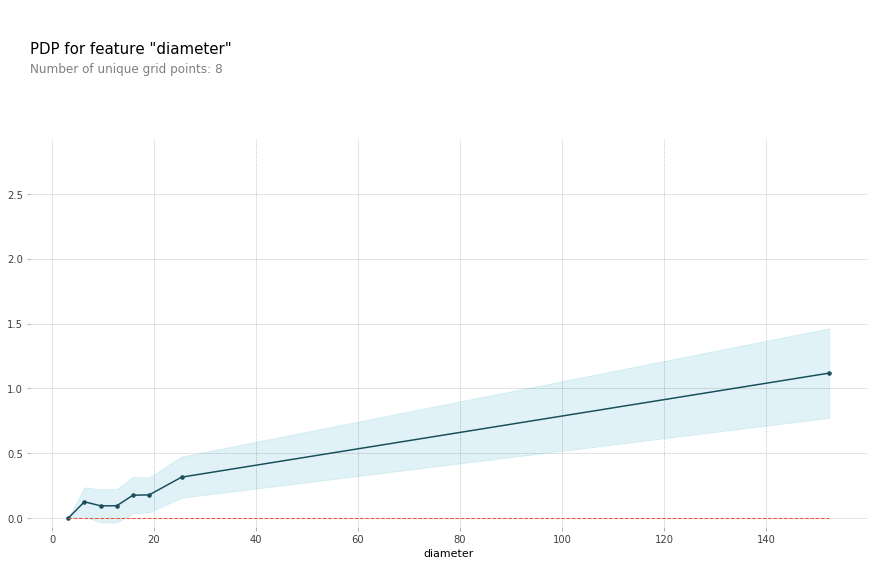

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

#plot image and save file to share wit da homies
pdp_plot(isolated, feature_name = feature)
#plt.savefig('diameter_plot.png')